In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../../..")

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-21 19:41:55.269676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 19:41:55.269695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
from librep.transforms import UMAP
from tabulate import tabulate

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [4]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1)': ['-']*9,
    'Topo-AEv2 (L=100)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │ -            │ -         

# Visualization helper

In [5]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../../data/old-views/KuHar/resampled_view_20Hz")

In [7]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [8]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [9]:
train

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,3325,-1.521897,-5.127366,-6.532153,-7.805943,10.992308,17.036004,-10.767749,-9.955230,-5.821859,...,9.102,9.101,12.127,12.126,17,300,2,900,1087,17
3326,3326,-1.980455,1.321672,5.392922,-3.234459,1.134713,-2.920856,0.090717,-1.113254,2.227080,...,25.198,25.197,28.219,28.220,17,300,1,1800,1090,17
3327,3327,-0.359406,-1.191011,-0.873361,-0.615347,0.933029,2.592225,-0.231447,0.818763,4.443685,...,33.363,33.362,36.387,36.386,17,300,2,3300,1090,17
3328,3328,-2.038564,1.391516,1.993335,0.860137,-0.599232,-2.793036,-1.663548,-2.873007,-0.120694,...,84.916,84.915,87.939,87.938,17,300,2,8400,1090,17


In [10]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Transforming KuHAR to 20Hzs

In [11]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [12]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [13]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [14]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [15]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [16]:
train_dataset_fft.X

array([[2.08923330e-02, 1.12081089e-01, 6.03699767e-02, ...,
        6.86907330e-03, 1.25349286e-02, 1.69158661e-02],
       [1.53802877e-02, 8.24343989e-02, 4.18766153e-02, ...,
        3.72912157e-03, 3.98584265e-03, 1.71193131e-02],
       [5.21272671e-02, 4.82816195e-02, 8.93573044e-02, ...,
        9.75422945e-03, 2.66463902e-02, 7.84359780e-03],
       ...,
       [2.46594280e+00, 2.97792077e+01, 2.58438841e+01, ...,
        1.43625028e+00, 7.98405975e-01, 2.66617405e-01],
       [3.12703194e+00, 2.12859482e+01, 9.31637610e+00, ...,
        4.71804217e-01, 9.06413206e-01, 6.75740676e-01],
       [1.48890233e+01, 6.63385820e+00, 8.58902995e+00, ...,
        3.19953749e-01, 1.27100790e-01, 3.83110579e-01]])

In [17]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [20]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [21]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [22]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Reducing with Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [23]:
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 0
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam = topoae_lambda,
    ae_kwargs = kwargs,
    input_shape = input_shape,
    patience=10
)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:279.3873, Loss-ae:279.3873, Loss-topo:126.8739
Epoch:2, P:10, Loss:272.4795, Loss-ae:272.4795, Loss-topo:332.7559
Epoch:3, P:10, Loss:278.0149, Loss-ae:278.0149, Loss-topo:218.0690
Epoch:4, P:9, Loss:247.0673, Loss-ae:247.0673, Loss-topo:178.7983
Epoch:5, P:10, Loss:224.7645, Loss-ae:224.7645, Loss-topo:128.1956
Epoch:6, P:10, Loss:249.7063, Loss-ae:249.7063, Loss-topo:434.0096
Epoch:7, P:9, Loss:226.5152, Loss-ae:226.5152, Loss-topo:324.3694
Epoch:8, P:8, Loss:195.9738, Loss-ae:195.9738, Loss-topo:1607.1806
Epoch:9, P:10, Loss:157.8963, Loss-ae:157.8963, Loss-topo:1620.1250
Epoch:10, P:10, Loss:174.9525, Loss-ae:174.9525, Loss-topo:1927.9837
Epoch:11, P:9, Loss:142.4352, Loss-ae:142.4352, Loss-topo:1368.1252
Epoch:12, P:10, Loss:194.6741, Loss-ae:194.6741, Loss-topo:3604.9906
Epoch:13, P:9, Loss:167.3474, Loss-ae:167.3474, Loss-topo:3400.3621
Epoch:14, P:8, Loss:165.5967, Loss-ae:165.5967, Loss-topo:2430.4939
Epoch:15, P:7, Loss:136.3475, Loss-ae:136.3475, Loss-top

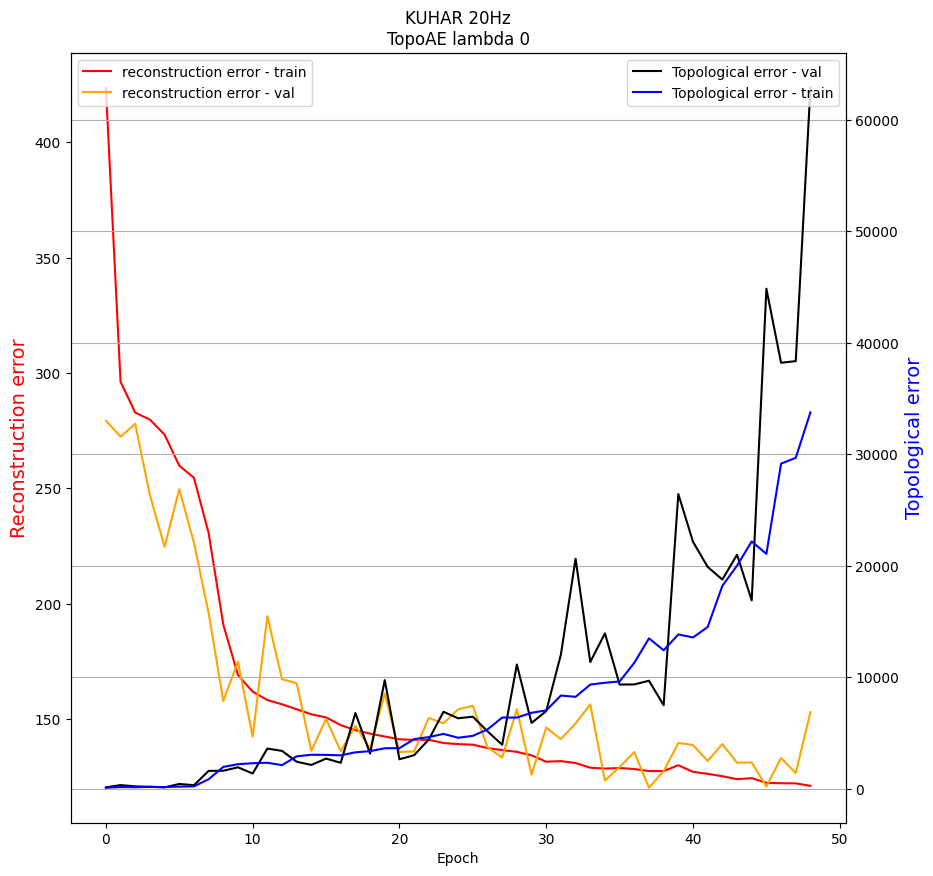

In [24]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [25]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [26]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [27]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [28]:
result = multi_run_experiment(train_pmd, test_pmd)

In [29]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.35449735449735453
F1 0.3722173260939174


In [30]:
table_info['Generic-AE'][0] = accuracy
table_info['Generic-AE'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.35449735449735453 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.3722173260939174  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -                   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -                   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Experiment for SVC

In [31]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [32]:
result = multi_run_experiment(train_pmd, test_pmd)

In [33]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.36243386243386244
F1 0.42699467638042926


In [34]:
table_info['Generic-AE'][2] = accuracy
table_info['Generic-AE'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.35449735449735453 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.3722173260939174  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.36243386243386244 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.42699467638042926 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Experiment for KNN

In [35]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [36]:
result = multi_run_experiment(train_pmd, test_pmd)

In [37]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.373015873015873
F1 0.38654912123608437


In [38]:
table_info['Generic-AE'][4] = accuracy
table_info['Generic-AE'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.35449735449735453 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.3722173260939174  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.36243386243386244 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.42699467638042926 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Obtain quality metrics

In [39]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [40]:
metrics_report

{'residual variance (pearson)': 0.11130453446920296,
 'residual variance (spearman)': 0.16414489932162069,
 'trustworthiness': 0.8657602665745755,
 'continuity': 0.9446562010918683,
 'co k nearest neighbor size': 0.3562665782493369,
 'local continuity meta criterion': 0.3137133867599752,
 'local property': 0.48742209524100016,
 'global property': 0.8878413787121888}

In [41]:
table_info['Generic-AE'][6] = metrics_report['trustworthiness']
table_info['Generic-AE'][7] = metrics_report['continuity']
table_info['Generic-AE'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │ -         

## Visualization

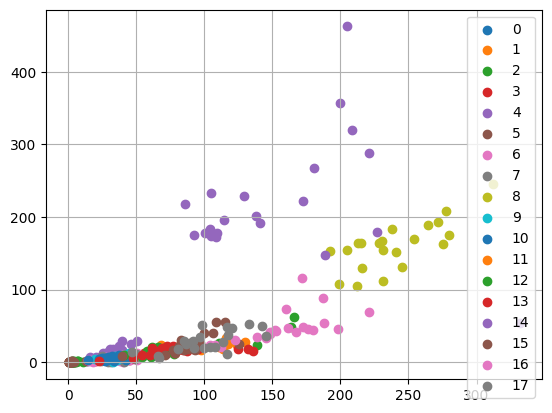

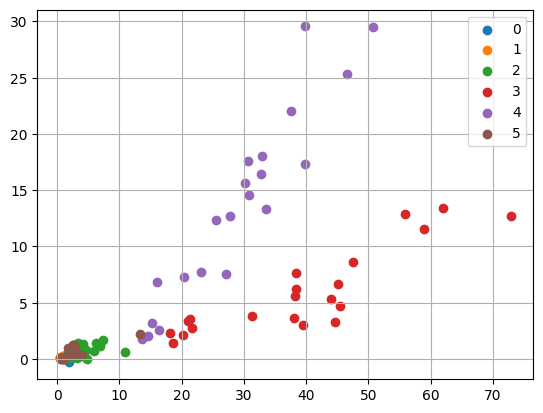

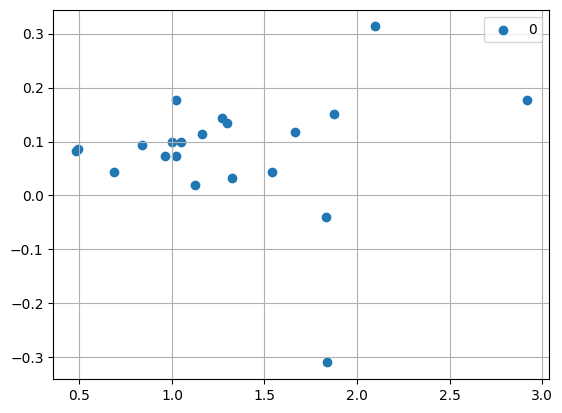

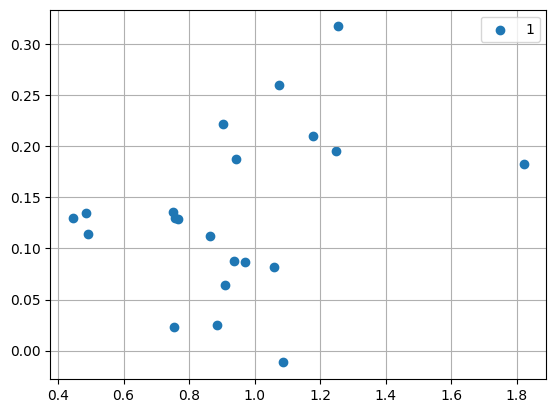

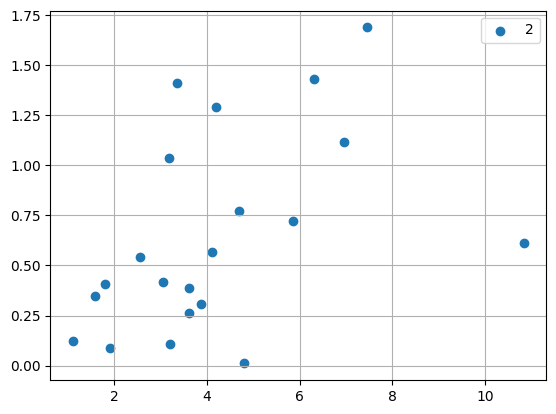

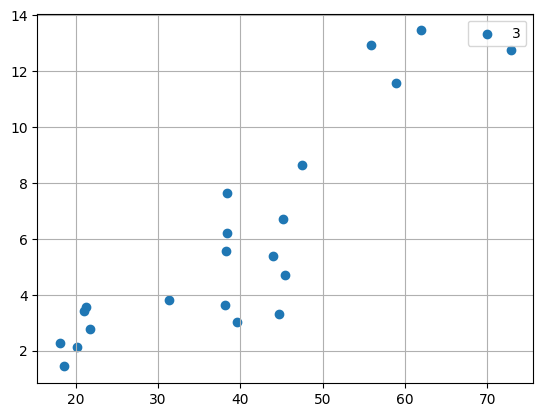

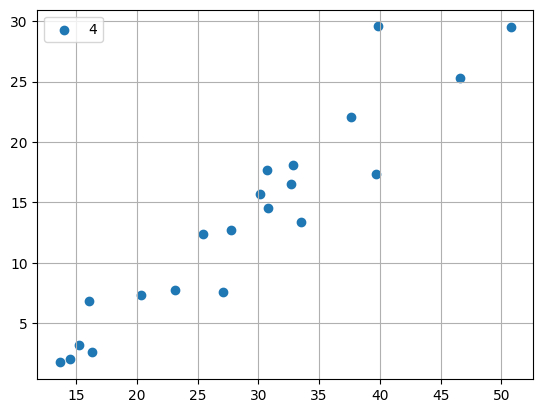

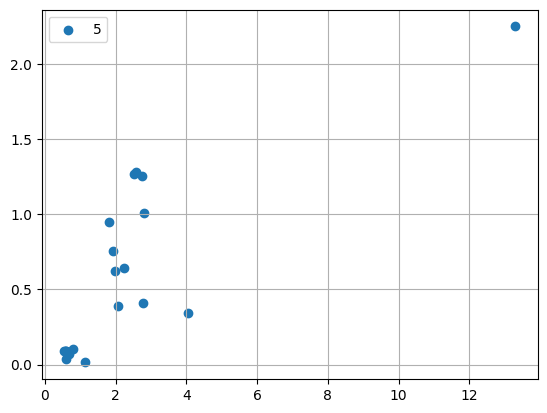

In [42]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=1)

In [43]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 1
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:310.8106, Loss-ae:287.3736, Loss-topo:23.4370
Epoch:2, P:10, Loss:309.7552, Loss-ae:297.0994, Loss-topo:12.6558
Epoch:3, P:10, Loss:281.9311, Loss-ae:272.1236, Loss-topo:9.8075
Epoch:4, P:10, Loss:265.4606, Loss-ae:255.9840, Loss-topo:9.4766
Epoch:5, P:10, Loss:262.1878, Loss-ae:253.1277, Loss-topo:9.0602
Epoch:6, P:10, Loss:299.1301, Loss-ae:293.2625, Loss-topo:5.8676
Epoch:7, P:9, Loss:278.3551, Loss-ae:271.3815, Loss-topo:6.9736
Epoch:8, P:8, Loss:238.4426, Loss-ae:235.8989, Loss-topo:2.5437
Epoch:9, P:10, Loss:216.4577, Loss-ae:214.8702, Loss-topo:1.5875
Epoch:10, P:10, Loss:198.1013, Loss-ae:194.8964, Loss-topo:3.2049
Epoch:11, P:10, Loss:186.1016, Loss-ae:182.1086, Loss-topo:3.9930
Epoch:12, P:10, Loss:183.8872, Loss-ae:179.3224, Loss-topo:4.5649
Epoch:13, P:10, Loss:170.4024, Loss-ae:165.9438, Loss-topo:4.4586
Epoch:14, P:10, Loss:194.7762, Loss-ae:189.8556, Loss-topo:4.9206
Epoch:15, P:9, Loss:185.3179, Loss-ae:181.4007, Loss-topo:3.9172
Epoch:16, P:8, Loss:

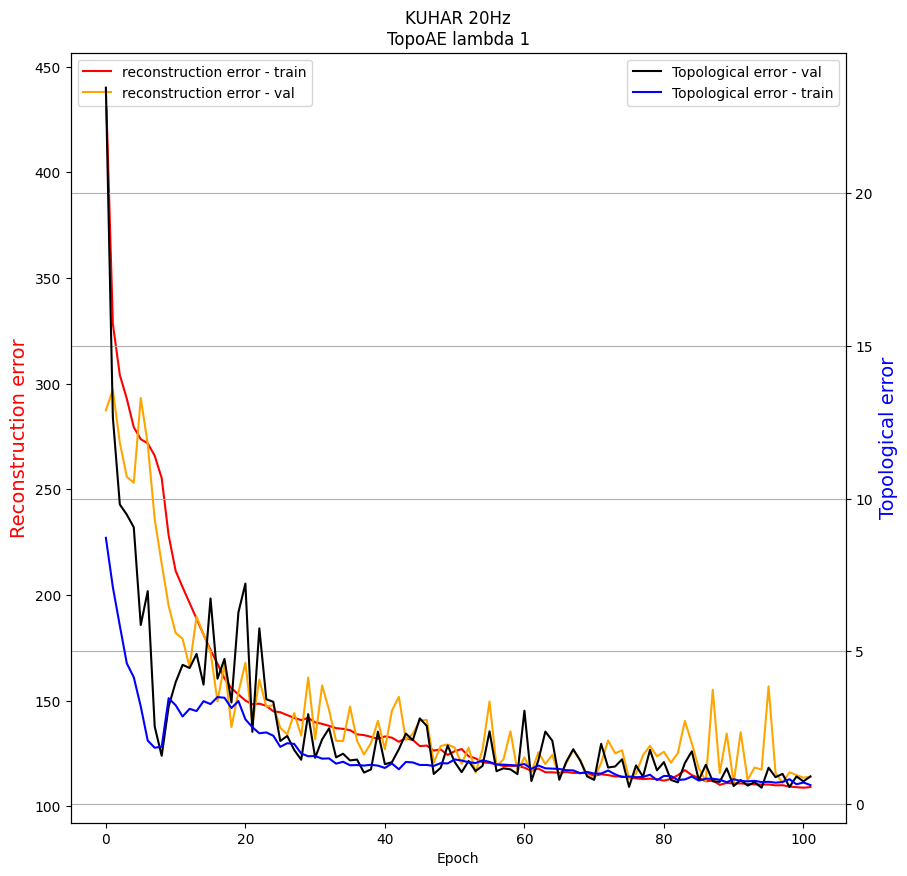

In [44]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [45]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [46]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [47]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [48]:
result = multi_run_experiment(train_pmd, test_pmd)

In [49]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5494708994708994
F1 0.5586702405165855


In [50]:
table_info['Topo-AEv2 (L=1)'][0] = accuracy
table_info['Topo-AEv2 (L=1)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)    │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │ 0.5494708994708994 │ -                   │
├─────────────────┼────────┼──────────────┼────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │ 0.5586702405165855 │ -                   │
├─────────────────┼────────┼──────────────┼────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │ -                  │ -                   │
├─────────────────┼────────┼──────────────┼────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │ -                  │ -                   │
├─────────────────┼────────┼──────────────┼────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │

## Experiment for SVC

In [51]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [52]:
result = multi_run_experiment(train_pmd, test_pmd)

In [53]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4603174603174603
F1 0.48600370572115204


In [54]:
table_info['Topo-AEv2 (L=1)'][2] = accuracy
table_info['Topo-AEv2 (L=1)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │ 0.5494708994708994  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │ 0.5586702405165855  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │ 0.4603174603174603  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │ 0.48600370572115204 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Experiment for KNN

In [55]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [56]:
result = multi_run_experiment(train_pmd, test_pmd)

In [57]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.5158730158730159
F1 0.5237021983860417


In [58]:
table_info['Topo-AEv2 (L=1)'][4] = accuracy
table_info['Topo-AEv2 (L=1)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │ 0.5494708994708994  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │ 0.5586702405165855  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │ 0.4603174603174603  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │ 0.48600370572115204 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Obtain quality metrics

In [59]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [60]:
metrics_report

{'residual variance (pearson)': 0.12919193389809458,
 'residual variance (spearman)': 0.1868392434574374,
 'trustworthiness': 0.9043205397620815,
 'continuity': 0.9620068774477027,
 'co k nearest neighbor size': 0.449104774535809,
 'local continuity meta criterion': 0.4065515830464473,
 'local property': 0.5001461843360889,
 'global property': 0.8645354124442727}

In [61]:
table_info['Topo-AEv2 (L=1)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=1)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=1)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │          0.549471 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │          0.55867  │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │          0.460317 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │          0.486004 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │          0

## Visualization

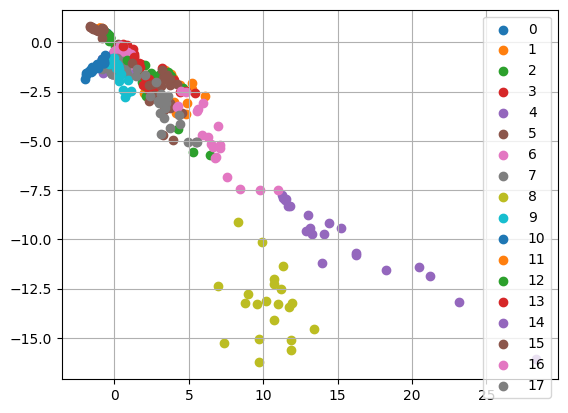

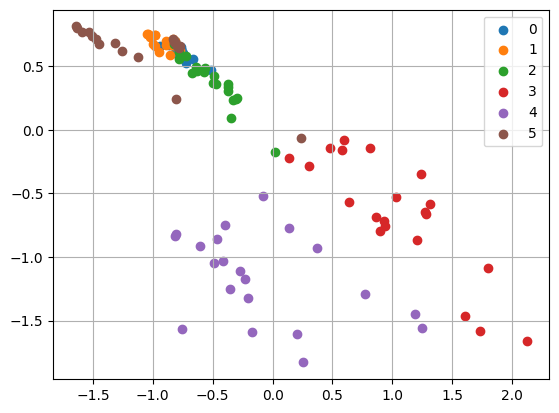

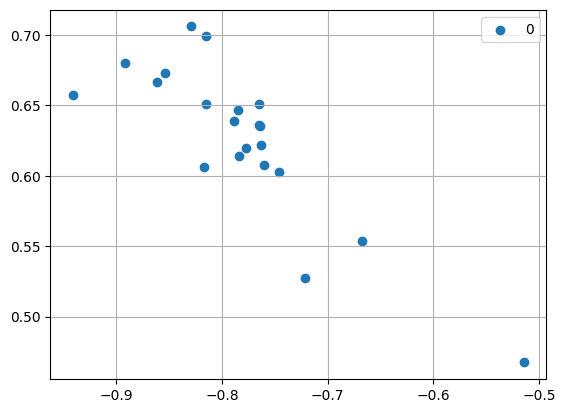

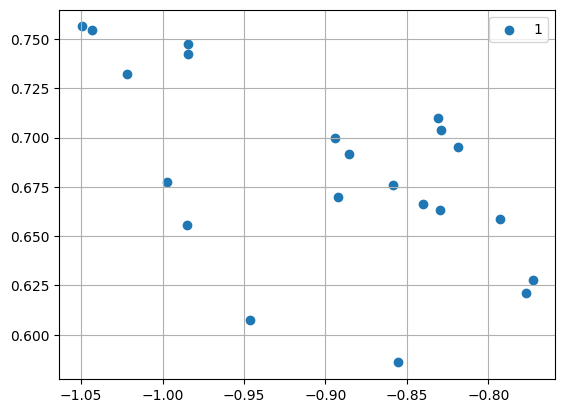

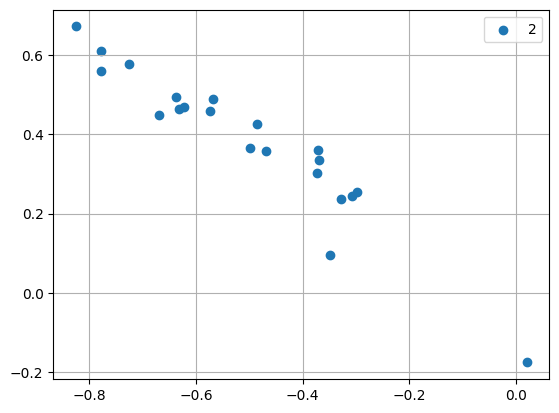

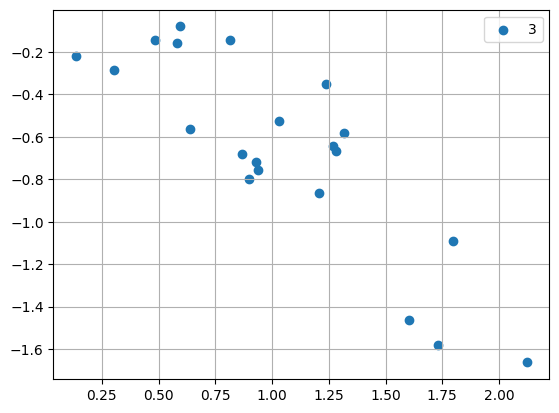

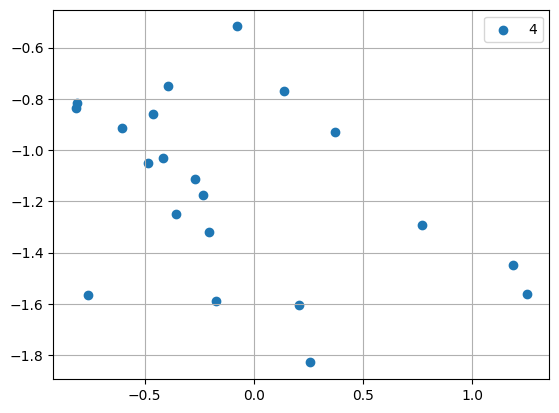

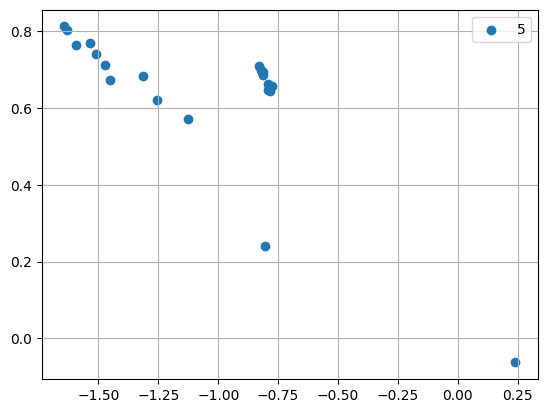

In [62]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=100)

In [63]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:390.4835, Loss-ae:388.5589, Loss-topo:0.0192
Epoch:2, P:10, Loss:402.8666, Loss-ae:370.7274, Loss-topo:0.3214
Epoch:3, P:9, Loss:319.5659, Loss-ae:288.2251, Loss-topo:0.3134
Epoch:4, P:10, Loss:269.2794, Loss-ae:267.4673, Loss-topo:0.0181
Epoch:5, P:10, Loss:279.1584, Loss-ae:271.5063, Loss-topo:0.0765
Epoch:6, P:9, Loss:326.8234, Loss-ae:315.9702, Loss-topo:0.1085
Epoch:7, P:8, Loss:246.8795, Loss-ae:245.5085, Loss-topo:0.0137
Epoch:8, P:10, Loss:227.8724, Loss-ae:225.8569, Loss-topo:0.0202
Epoch:9, P:10, Loss:215.6773, Loss-ae:214.2817, Loss-topo:0.0140
Epoch:10, P:10, Loss:214.5885, Loss-ae:213.7001, Loss-topo:0.0089
Epoch:11, P:10, Loss:259.1572, Loss-ae:252.1734, Loss-topo:0.0698
Epoch:12, P:9, Loss:213.7684, Loss-ae:213.0493, Loss-topo:0.0072
Epoch:13, P:10, Loss:252.1182, Loss-ae:248.1764, Loss-topo:0.0394
Epoch:14, P:9, Loss:214.7068, Loss-ae:211.9394, Loss-topo:0.0277
Epoch:15, P:8, Loss:259.4127, Loss-ae:254.2679, Loss-topo:0.0514
Epoch:16, P:7, Loss:178.9

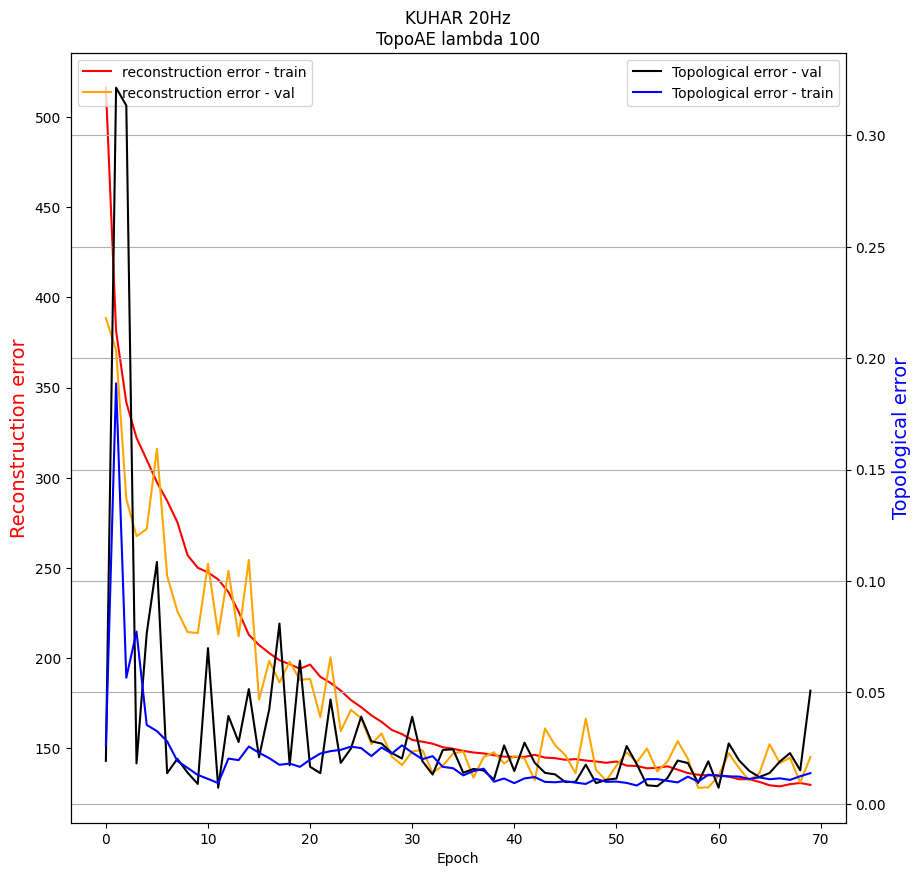

In [64]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [65]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [66]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [67]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [68]:
result = multi_run_experiment(train_pmd, test_pmd)

In [69]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4669312169312169
F1 0.4727321226190416


In [70]:
table_info['Topo-AEv2 (L=100)'][0] = accuracy
table_info['Topo-AEv2 (L=100)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │          0.549471 │ 0.4669312169312169  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │          0.55867  │ 0.4727321226190416  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │          0.460317 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │          0.486004 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │          0

## Experiment for SVC

In [71]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [72]:
result = multi_run_experiment(train_pmd, test_pmd)

In [73]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4576719576719577
F1 0.5000106037479266


In [74]:
table_info['Topo-AEv2 (L=100)'][2] = accuracy
table_info['Topo-AEv2 (L=100)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │          0.549471 │ 0.4669312169312169  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │          0.55867  │ 0.4727321226190416  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │          0.460317 │ 0.4576719576719577  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │          0.486004 │ 0.5000106037479266  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │          0

## Experiment for KNN

In [75]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [76]:
result = multi_run_experiment(train_pmd, test_pmd)

In [77]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4497354497354497
F1 0.4551532403116286


In [78]:
table_info['Topo-AEv2 (L=100)'][4] = accuracy
table_info['Topo-AEv2 (L=100)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │          0.549471 │ 0.4669312169312169  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │          0.55867  │ 0.4727321226190416  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │          0.460317 │ 0.4576719576719577  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │          0.486004 │ 0.5000106037479266  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │          0

## Obtain quality metrics

In [79]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [80]:
metrics_report

{'residual variance (pearson)': 0.17632209246717123,
 'residual variance (spearman)': 0.26412702509832053,
 'trustworthiness': 0.8688430861811796,
 'continuity': 0.9510932459936663,
 'co k nearest neighbor size': 0.36687665782493367,
 'local continuity meta criterion': 0.32432346633557196,
 'local property': 0.49324822816820735,
 'global property': 0.8678774500443308}

In [81]:
table_info['Topo-AEv2 (L=100)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=100)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=100)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.354497 │          0.549471 │            0.466931 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.372217 │          0.55867  │            0.472732 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.362434 │          0.460317 │            0.457672 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.426995 │          0.486004 │            0.500011 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.373016 │          0

## Visualization

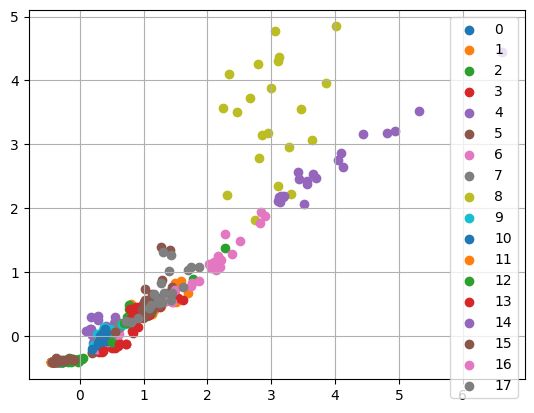

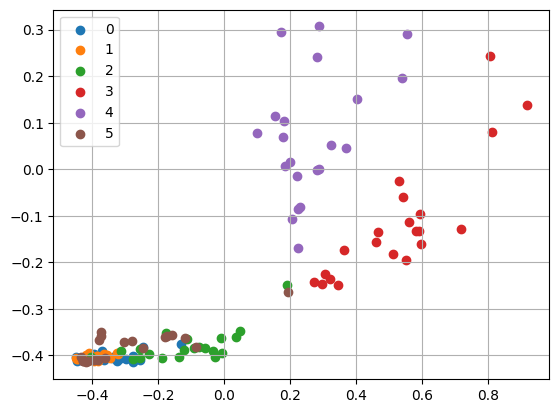

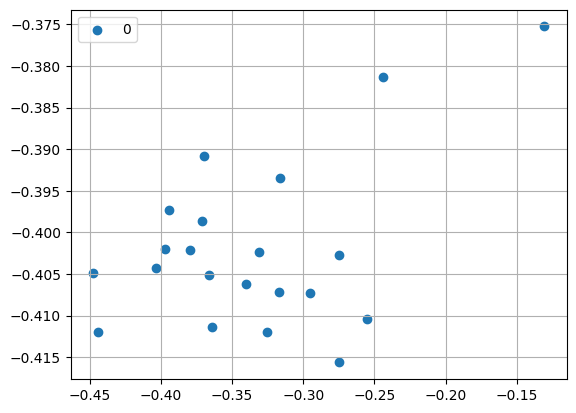

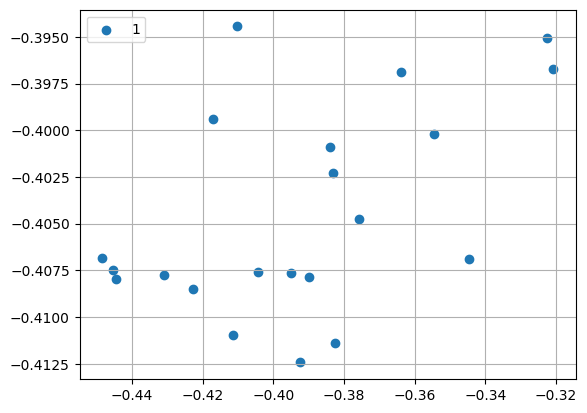

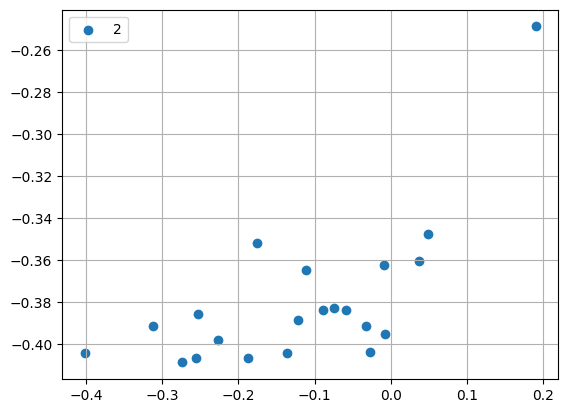

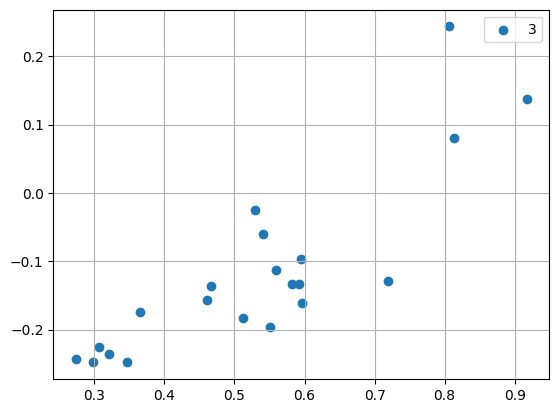

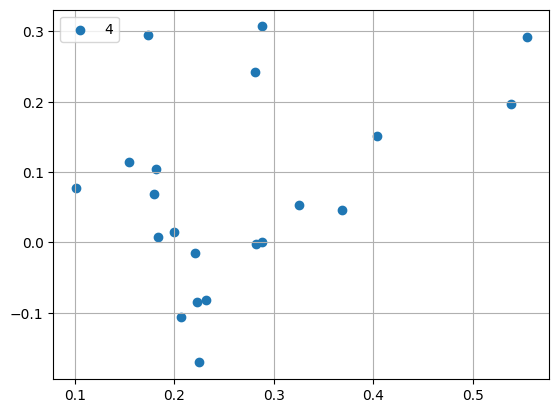

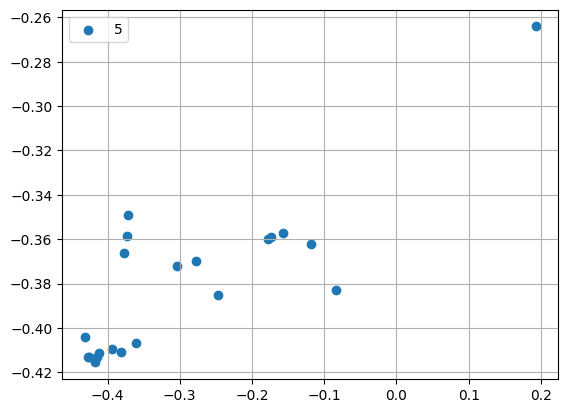

In [82]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [83]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [84]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [85]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [86]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [87]:
result = multi_run_experiment(train_pmd, test_pmd)

In [88]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8007936507936508
F1 0.8057165118989165


In [89]:
table_info['UMAP'][0] = accuracy
table_info['UMAP'][1] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8007936507936508 │     0.354497 │          0.549471 │            0.466931 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8057165118989165 │     0.372217 │          0.55867  │            0.472732 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -                  │     0.362434 │          0.460317 │            0.457672 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -                  │     0.426995 │          0.486004 │            0.500011 │
├─────────────────┼─

## Experiment for SVC

In [90]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [91]:
result = multi_run_experiment(train_pmd, test_pmd)

In [92]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8068783068783069
F1 0.8117764553802957


In [93]:
table_info['UMAP'][2] = accuracy
table_info['UMAP'][3] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8007936507936508 │     0.354497 │          0.549471 │            0.466931 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8057165118989165 │     0.372217 │          0.55867  │            0.472732 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.8068783068783069 │     0.362434 │          0.460317 │            0.457672 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8117764553802957 │     0.426995 │          0.486004 │            0.500011 │
├─────────────────┼─

## Experiment for KNN

In [94]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [95]:
result = multi_run_experiment(train_pmd, test_pmd)

In [96]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.7936507936507936
F1 0.798374139315226


In [97]:
table_info['UMAP'][4] = accuracy
table_info['UMAP'][5] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8007936507936508 │     0.354497 │          0.549471 │            0.466931 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8057165118989165 │     0.372217 │          0.55867  │            0.472732 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.8068783068783069 │     0.362434 │          0.460317 │            0.457672 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8117764553802957 │     0.426995 │          0.486004 │            0.500011 │
├─────────────────┼─

## Obtain quality metrics

In [98]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [99]:
metrics_report

{'residual variance (pearson)': 0.8120007205655928,
 'residual variance (spearman)': 0.7549657404934842,
 'trustworthiness': 0.8962426614840886,
 'continuity': 0.9017741022946869,
 'co k nearest neighbor size': 0.4878978779840849,
 'local continuity meta criterion': 0.4453446864947232,
 'local property': 0.3984783798576902,
 'global property': 0.7073534361852946}

In [100]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.800794 │     0.354497 │          0.549471 │            0.466931 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.805717 │     0.372217 │          0.55867  │            0.472732 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.806878 │     0.362434 │          0.460317 │            0.457672 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.811776 │     0.426995 │          0.486004 │            0.500011 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ 0.793651 │  

## Visualization

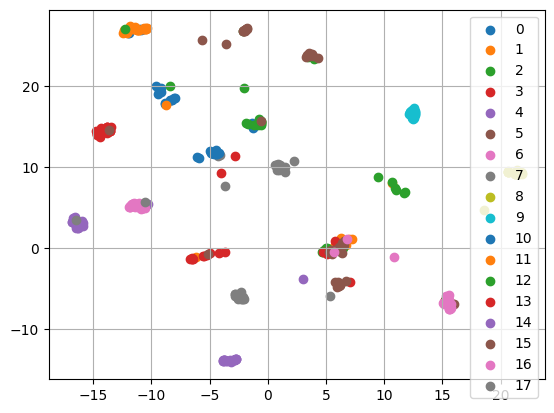

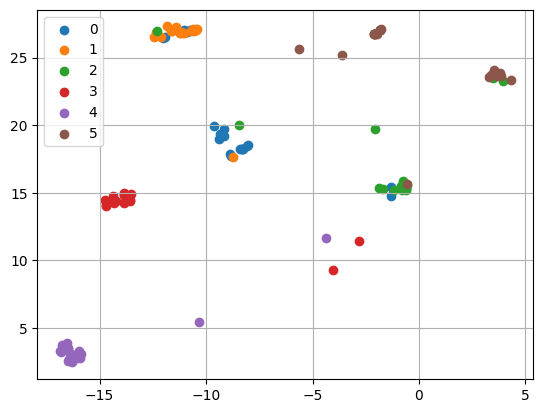

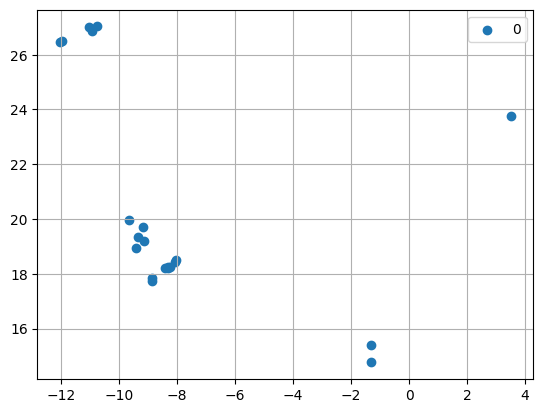

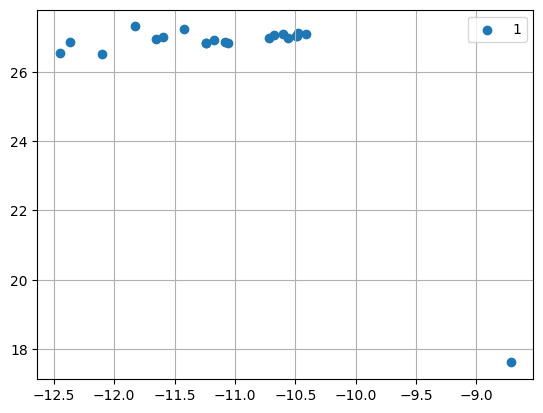

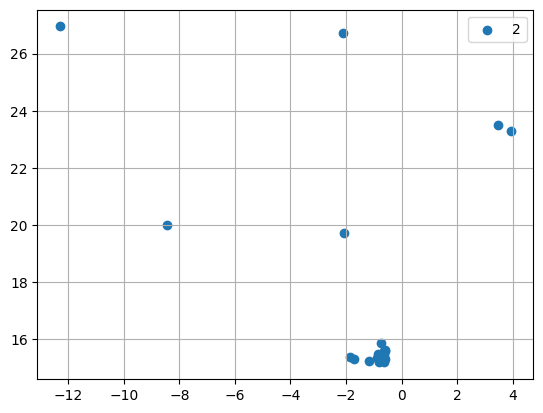

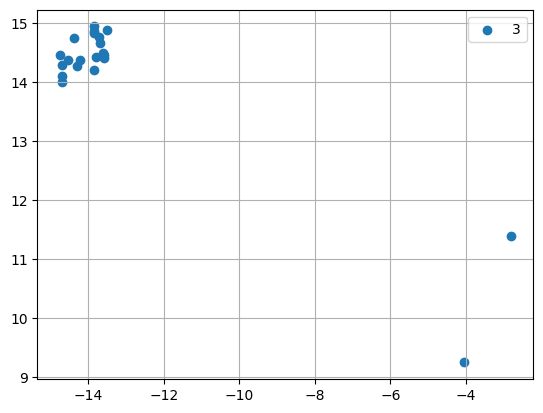

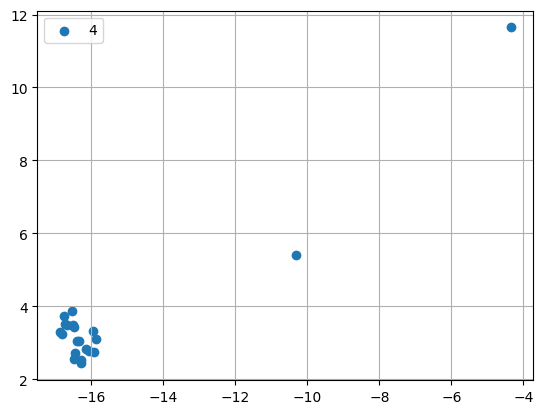

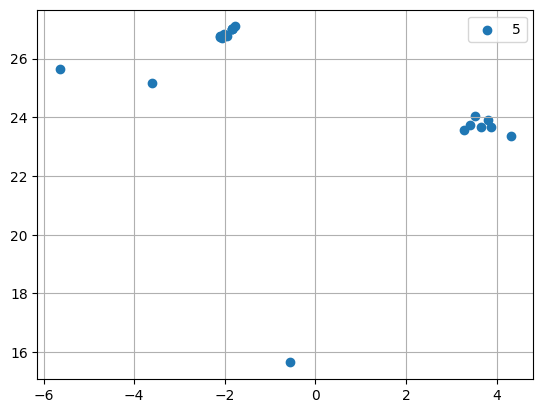

In [101]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run